# Hands-on Lab: Build an Interactive Dashboard with Plotly Dash

In [ ]:
# Import required libraries
import pandas as pd
import dash
from dash import html
from dash import dcc
from dash.dependencies import Input, Output
import plotly.express as px

# Read the airline data into pandas dataframe
spacex_df = pd.read_csv("spacex_launch_dash.csv") # https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv
max_payload = spacex_df['Payload Mass (kg)'].max()
min_payload = spacex_df['Payload Mass (kg)'].min()

# Create a dash application
app = dash.Dash(__name__)

# Create an app layout
app.layout = html.Div(children=[html.H1('SpaceX Launch Records Dashboard',
                                        style={'textAlign': 'center', 'color': '#503D36',
                                               'font-size': 40}),
                                # TASK 1: Add a dropdown list to enable Launch Site selection
                                # The default select value is for ALL sites
                                dcc.Dropdown(id='site-dropdown',options=[
                                    {'label': 'All Sites', 'value': 'ALL'}] + [{'label': site, 'value': site} for site in spacex_df['Launch Site'].unique()],
                                    value='ALL',
                                    placeholder="Select a Launch Site here",
                                    searchable=True    
                                ),
                                html.Br(),

                                # TASK 2: Add a pie chart to show the total successful launches count for all sites
                                # If a specific launch site was selected, show the Success vs. Failed counts for the site
                                html.Div(dcc.Graph(id='success-pie-chart')),
                                html.Br(),

                                html.P("Payload range (Kg):"),
                                # TASK 3: Add a slider to select payload range
                                #dcc.RangeSlider(id='payload-slider',...)
                                dcc.RangeSlider(
                                    id='payload-slider',
                                    min=0, max=10000, step=1000, 
                                    marks={i: f'{i}' for i in range(0, 10001, 1000)},
                                    value=[min_payload, max_payload]
                                ),

                                # TASK 4: Add a scatter chart to show the correlation between payload and launch success
                                html.Div(dcc.Graph(id='success-payload-scatter-chart')),
                                ])

# TASK 2:
# Add a callback function for `site-dropdown` as input, `success-pie-chart` as output
@app.callback(
    Output(component_id='success-pie-chart', component_property='figure'),
    Input(component_id='site-dropdown', component_property='value')
)
def get_pie_chart(entered_site):
    if entered_site == 'ALL':
        # Count total success launches (class=1) for each site
        success_counts = spacex_df[spacex_df['class'] == 1]['Launch Site'].value_counts().reset_index()
        success_counts.columns = ['Launch Site', 'Successes']
        fig = px.pie(success_counts, 
                     values='Successes', 
                     names='Launch Site', 
                     title='Total Successful Launches by Site')
        return fig
    else:
        # Filter data for selected site
        filtered_df = spacex_df[spacex_df['Launch Site'] == entered_site]
        site_counts = filtered_df['class'].value_counts().reset_index()
        site_counts.columns = ['Outcome', 'Count']
        site_counts['Outcome'] = site_counts['Outcome'].replace({1: 'Success', 0: 'Failure'})
        fig = px.pie(site_counts, 
                     values='Count', 
                     names='Outcome', 
                     title=f'Total Successful Launches by {entered_site}')
        return fig


# TASK 4:
# Add a callback function for `site-dropdown` and `payload-slider` as inputs, `success-payload-scatter-chart` as output
@app.callback(
    Output(component_id='success-payload-scatter-chart', component_property='figure'),
    [Input(component_id='site-dropdown', component_property='value'),
     Input(component_id='payload-slider', component_property='value')]
)
def get_scatter_chart(selected_site, payload_range):
    # Filter payload range
    low, high = payload_range
    payload_filtered_df = spacex_df[
        (spacex_df['Payload Mass (kg)'] >= low) &
        (spacex_df['Payload Mass (kg)'] <= high)
    ]

    if selected_site == 'ALL':
        # No site filter applied
        fig = px.scatter(
            payload_filtered_df,
            x='Payload Mass (kg)',
            y='class',
            color='Booster Version Category',
            title='Correlation between Payload and Success For all Sites'
        )
    else:
        # Filter by selected site
        site_filtered_df = payload_filtered_df[payload_filtered_df['Launch Site'] == selected_site]
        fig = px.scatter(
            site_filtered_df,
            x='Payload Mass (kg)',
            y='class',
            color='Booster Version Category',
            title=f'Correlation between Payload and Success For {selected_site}'
        )

    return fig


# Run the app
if __name__ == '__main__':
    app.run()


![Screenshot 2025-07-16 151605.png](<attachment:Screenshot 2025-07-16 151605.png>)
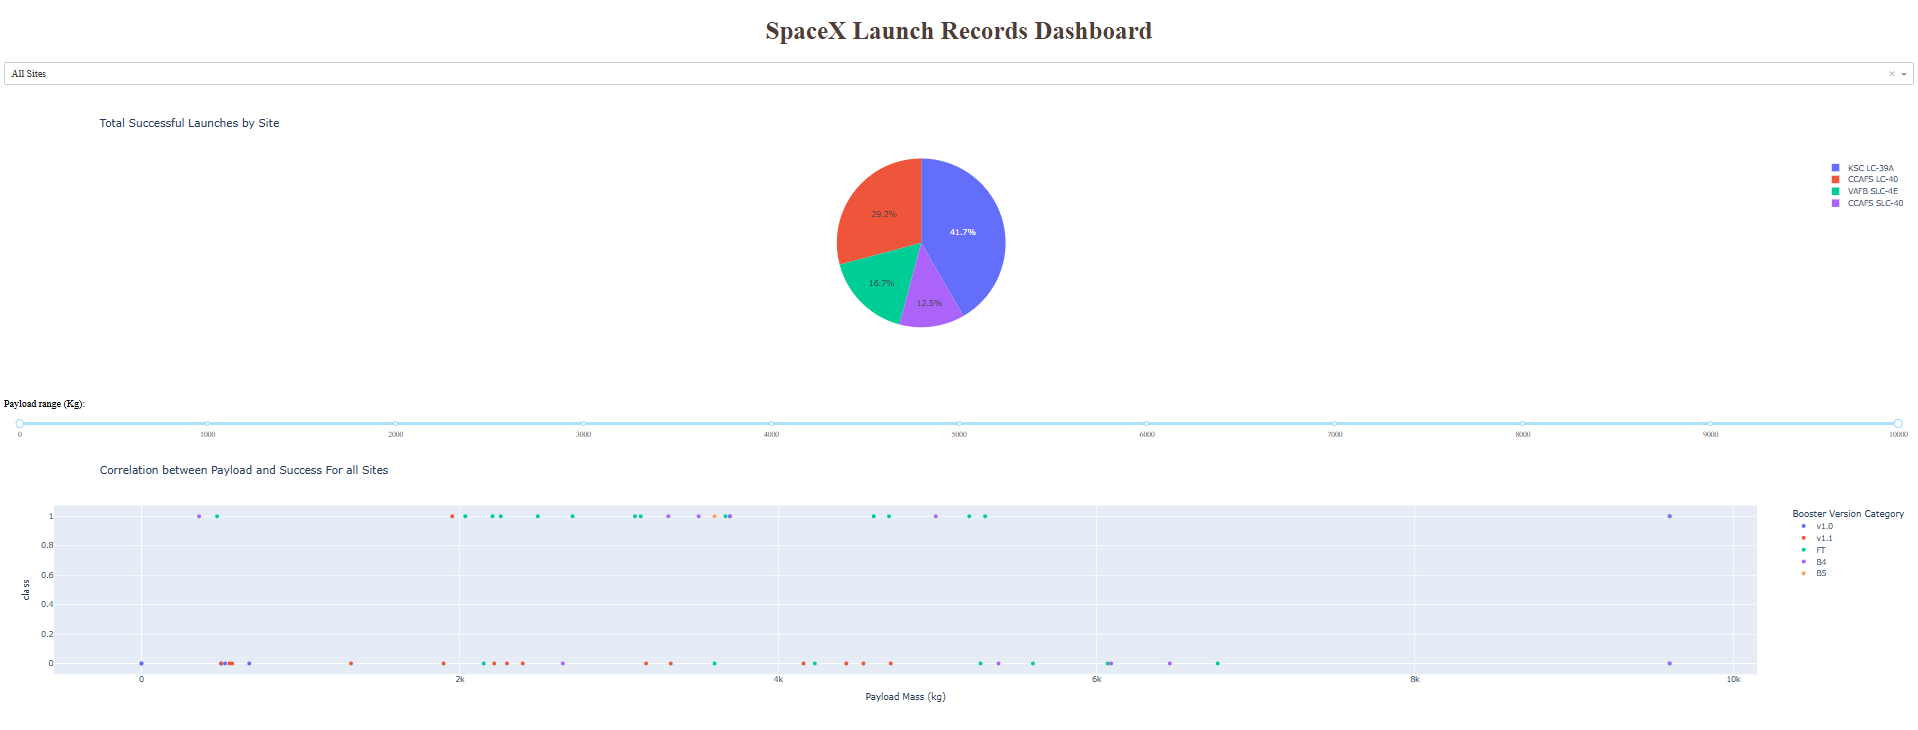